## Dataset 불러오기

In [275]:
import pandas as pd

train = pd.read_csv("C:/Users/hu612/Desktop/School/sooda/주차수요 예측 ai/dataset/train.csv")
test = pd.read_csv("C:/Users/hu612/Desktop/School/sooda/주차수요 예측 ai/dataset/test.csv")
age_gender = pd.read_csv("C:/Users/hu612/Desktop/School/sooda/주차수요 예측 ai/dataset/age_gender_info.csv")

In [276]:
train.shape

(2952, 15)

## Columns명 변경 : 지하철, 버스

In [277]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', '단지내주차면수', '등록차량수'],
      dtype='object')

In [278]:
train['단지코드'].unique().shape

(423,)

In [279]:
train.columns = ['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '지하철',
       '버스', '단지내주차면수', '등록차량수']

## 임대보증금, 임대료 문자열 0으로 변경

In [280]:
train.loc[train['임대보증금'] == "-",'임대보증금'] = 0

In [281]:
train.loc[train['임대료'] == "-",'임대료'] = 0

## float -> int 변환 : 전용면적, 단지내주차면수, 등록차량수, 공가수

나중에 임대보증금 임대료도 null값 다 채우고 int 변환

In [282]:
# 전용면적 평수 변환
train['전용면적']=round(train['전용면적']*0.3025,0)

In [283]:
train[['전용면적','공가수','단지내주차면수','등록차량수']] = train[['전용면적','공가수','단지내주차면수','등록차량수']].astype(int)

## 버스 null값 4개 처리

In [284]:
train.isnull().sum()

단지코드          0
총세대수          0
임대건물구분        0
지역            0
공급유형          0
전용면적          0
전용면적별세대수      0
공가수           0
자격유형          0
임대보증금       569
임대료         569
지하철         211
버스            4
단지내주차면수       0
등록차량수         0
dtype: int64

In [285]:
# 버스 null값 아파트가 양산에 있다고 추정
# 근처 버스정류장을 새어보니 2개가 있었고
# 양산은 지하철이 도로를 다니지 않기 때문에 0개를 넣음
train.loc[train['버스'].isnull(),['지하철','버스']] = [0,2]

In [286]:
# 클린
train.isnull().sum()

단지코드          0
총세대수          0
임대건물구분        0
지역            0
공급유형          0
전용면적          0
전용면적별세대수      0
공가수           0
자격유형          0
임대보증금       569
임대료         569
지하철         207
버스            0
단지내주차면수       0
등록차량수         0
dtype: int64

## 지하철 null값 0으로 채워주기


광역시에 지하철이 많이 다니기 때문에 광역시를 제외한 시,도에는 0을 채워주었다.
그러고 광역시끼리 해서 평균을 계산해봤을때, 0.xx가 나와서 null값을 0으로 채워주기로 하였다.

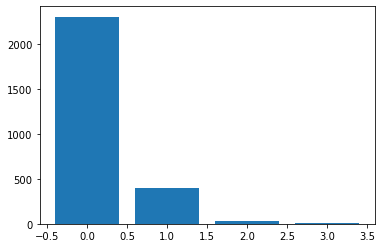

In [287]:
import matplotlib.pyplot as plt
x = [0,1,2,3]
y = [2306,400,33,6] # nan:230

plt.bar(x,y)
plt.show()

In [288]:
train['지하철'].fillna(0, inplace=True) 

## 총세대수 != sum(전용면적별세대수)

In [289]:
# 총세대수와 전용면적별세대수의 합이 다르기 때문에
# 어떤 단지코드가 다른지 알아보기 위한 코드

code=train.groupby(['단지코드'])
code=code.agg({'총세대수':'mean','전용면적별세대수':'sum'}).reset_index()
diff=[]
for i in range(len(code)):
    if code['총세대수'][i]!=code['전용면적별세대수'][i]:
        diff.append(code['단지코드'][i])
print(diff)  
len(diff)

['C1024', 'C1068', 'C1156', 'C1206', 'C1218', 'C1312', 'C1344', 'C1424', 'C1490', 'C1584', 'C1695', 'C1732', 'C1740', 'C1804', 'C1850', 'C1894', 'C1910', 'C1925', 'C1970', 'C2013', 'C2139', 'C2142', 'C2156', 'C2186', 'C2225', 'C2245', 'C2298', 'C2319', 'C2362', 'C2405', 'C2433', 'C2453', 'C2470', 'C2508', 'C2520', 'C2549', 'C2556', 'C2568', 'C2620', 'C2644']


40

In [290]:
for i in diff:
    code[code['단지코드']==i]

총세대수 - 분양, 임대<br>
전용면적별세대수 - 임대를 포함시킨다.

합의 차이가 1 나는 경우 대부분 상가가 분양된 경우가 많다.

In [291]:
train

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,12,134,38,A,15667000,103680,0.0,3.0,1425,1015
1,C2483,900,아파트,경상북도,국민임대,12,15,38,A,15667000,103680,0.0,3.0,1425,1015
2,C2483,900,아파트,경상북도,국민임대,16,385,38,A,27304000,184330,0.0,3.0,1425,1015
3,C2483,900,아파트,경상북도,국민임대,16,15,38,A,27304000,184330,0.0,3.0,1425,1015
4,C2483,900,아파트,경상북도,국민임대,16,41,38,A,27304000,184330,0.0,3.0,1425,1015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,C2532,239,아파트,강원도,국민임대,15,19,7,A,11346000,116090,0.0,1.0,166,146
2948,C2532,239,아파트,강원도,국민임대,15,34,7,A,14005000,142310,0.0,1.0,166,146
2949,C2532,239,아파트,강원도,국민임대,16,34,7,A,14005000,142310,0.0,1.0,166,146
2950,C2532,239,아파트,강원도,국민임대,16,114,7,A,14005000,142310,0.0,1.0,166,146


### train 지역별 빈칸 결측치 확인 및 결측치 제외 평균 살펴보기

In [292]:
train['지역'].unique()

array(['경상북도', '경상남도', '대전광역시', '경기도', '전라북도', '강원도', '광주광역시', '충청남도',
       '부산광역시', '제주특별자치도', '울산광역시', '충청북도', '전라남도', '대구광역시', '서울특별시',
       '세종특별자치시'], dtype=object)

In [293]:
df = train[(train['지역']=="경상북도") & (train['임대건물구분']=='아파트')]

In [294]:
df[['임대보증금','임대료']].isnull().sum()

임대보증금    0
임대료      0
dtype: int64

In [295]:
# 임대보증금이랑 임대료 전부 object형
df['임대보증금'].astype('int32').mean()

19863428.57142857

In [296]:
df1 = train[(train['지역']=="경상북도") & (train['임대건물구분']=='상가')]
df1[['임대보증금','임대료']].isnull().sum()

임대보증금    0
임대료      0
dtype: int64

In [297]:
df = train[(train['지역']=="경상남도") & (train['임대건물구분']=='아파트')]
df[['임대보증금','임대료']].isnull().sum()

임대보증금    0
임대료      0
dtype: int64

In [298]:
df1 = train[(train['지역']=="경상남도") & (train['임대건물구분']=='상가')]
df1[['임대보증금','임대료']].isnull().sum()

임대보증금    97
임대료      97
dtype: int64

In [299]:
df1.shape

(97, 15)

In [300]:
df4 = train[(train['지역']=="대전광역시") & (train['임대건물구분']=='아파트')]
#df4[['임대보증금','임대료']].isnull().sum()

In [301]:
df4 = df4.dropna(axis=0)

In [302]:
df4['임대보증금'].astype('int32').mean()

23559582.19178082

In [303]:
df4['임대료'].astype('int32').mean()

173557.80821917808

In [304]:
df5 = train[(train['지역']=="대전광역시") & (train['임대건물구분']=='상가')]
df5[['임대보증금','임대료']].isnull().sum()

임대보증금    113
임대료      113
dtype: int64

In [305]:
df5 = df5.dropna(axis=0)
print(df5['임대보증금'].astype('int32').mean())
print(df5['임대료'].astype('int32').mean())

nan
nan


In [306]:
df5['임대보증금'].unique()

array([], dtype=object)

In [307]:
df5['임대료'].unique()

array([], dtype=object)

In [308]:
df5

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수


In [309]:
df6 = train[(train['지역']=="경기도") & (train['임대건물구분']=='아파트')]
df6[['임대보증금','임대료']].isnull().sum()

임대보증금    0
임대료      0
dtype: int64

In [310]:
df6 = train[(train['지역']=="경기도") & (train['임대건물구분']=='상가')]
df6[['임대보증금','임대료']].isnull().sum()

임대보증금    0
임대료      0
dtype: int64

In [311]:
df6 = train[(train['지역']=="전라북도") & (train['임대건물구분']=='아파트')]
df6[['임대보증금','임대료']].isnull().sum()

임대보증금    0
임대료      0
dtype: int64

In [312]:
df6 = train[(train['지역']=="전라북도") & (train['임대건물구분']=='상가')]
df6[['임대보증금','임대료']].isnull().sum()

임대보증금    0
임대료      0
dtype: int64

In [313]:
df6 = train[(train['지역']=="강원도") & (train['임대건물구분']=='아파트')]
df6[['임대보증금','임대료']].isnull().sum()

임대보증금    0
임대료      0
dtype: int64

In [314]:
df6 = train[(train['지역']=="강원도") & (train['임대건물구분']=='상가')]
df6[['임대보증금','임대료']].isnull().sum()

임대보증금    31
임대료      31
dtype: int64

In [315]:
df6 = df6.dropna(axis=0)
print(df6['임대보증금'].astype('int32').mean())
print(df6['임대료'].astype('int32').mean())

nan
nan


In [316]:
df6 = train[(train['지역']=="광주광역시") & (train['임대건물구분']=='아파트')]
df6[['임대보증금','임대료']].isnull().sum()

임대보증금    0
임대료      0
dtype: int64

In [317]:
df6 = train[(train['지역']=="광주광역시") & (train['임대건물구분']=='상가')]
df6[['임대보증금','임대료']].isnull().sum()

임대보증금    0
임대료      0
dtype: int64

In [318]:
df6 = train[(train['지역']=="충청남도") & (train['임대건물구분']=='아파트')]
df6[['임대보증금','임대료']].isnull().sum()

임대보증금    0
임대료      0
dtype: int64

In [319]:
df6 = train[(train['지역']=="충청남도") & (train['임대건물구분']=='상가')]
df6[['임대보증금','임대료']].isnull().sum()

임대보증금    76
임대료      76
dtype: int64

In [320]:
df6 = df6.dropna(axis=0)
#print(df6['임대보증금'].astype('int32').mean())
#print(df6['임대료'].astype('int32').mean())

In [321]:
df6

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수


In [322]:
df6 = train[(train['지역']=="부산광역시") & (train['임대건물구분']=='아파트')]
df6[['임대보증금','임대료']].isnull().sum()

임대보증금    0
임대료      0
dtype: int64

In [323]:
df6 = train[(train['지역']=="부산광역시") & (train['임대건물구분']=='상가')]
df6[['임대보증금','임대료']].isnull().sum()

임대보증금    220
임대료      220
dtype: int64

In [324]:
df6

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
371,C2135,1116,상가,부산광역시,임대상가,4,1,10,D,NaN,NaN,1.0,3.0,262,127
372,C2135,1116,상가,부산광역시,임대상가,6,1,10,D,NaN,NaN,1.0,3.0,262,127
373,C2135,1116,상가,부산광역시,임대상가,6,1,10,D,NaN,NaN,1.0,3.0,262,127
374,C2135,1116,상가,부산광역시,임대상가,6,1,10,D,NaN,NaN,1.0,3.0,262,127
375,C2135,1116,상가,부산광역시,임대상가,6,1,10,D,NaN,NaN,1.0,3.0,262,127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,C1439,1755,상가,부산광역시,임대상가,12,1,29,D,NaN,NaN,1.0,3.0,270,172
613,C1439,1755,상가,부산광역시,임대상가,12,1,29,D,NaN,NaN,1.0,3.0,270,172
614,C1439,1755,상가,부산광역시,임대상가,19,1,29,D,NaN,NaN,1.0,3.0,270,172
615,C1439,1755,상가,부산광역시,임대상가,122,1,29,D,NaN,NaN,1.0,3.0,270,172


In [325]:
df6 = df6.dropna(axis=0)
print(df6['임대보증금'].astype('int32').mean())
print(df6['임대료'].astype('int32').mean())

nan
nan


In [326]:
df = train[train['지역']=='대구광역시']

In [327]:
df['임대건물구분'].unique()

array(['아파트'], dtype=object)

In [328]:
df6 = train[(train['지역']=="부산광역시") & (train['임대건물구분']=='상가')]
df6[['임대보증금','임대료']].isnull().sum()

임대보증금    220
임대료      220
dtype: int64

In [329]:
df6

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
371,C2135,1116,상가,부산광역시,임대상가,4,1,10,D,NaN,NaN,1.0,3.0,262,127
372,C2135,1116,상가,부산광역시,임대상가,6,1,10,D,NaN,NaN,1.0,3.0,262,127
373,C2135,1116,상가,부산광역시,임대상가,6,1,10,D,NaN,NaN,1.0,3.0,262,127
374,C2135,1116,상가,부산광역시,임대상가,6,1,10,D,NaN,NaN,1.0,3.0,262,127
375,C2135,1116,상가,부산광역시,임대상가,6,1,10,D,NaN,NaN,1.0,3.0,262,127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,C1439,1755,상가,부산광역시,임대상가,12,1,29,D,NaN,NaN,1.0,3.0,270,172
613,C1439,1755,상가,부산광역시,임대상가,12,1,29,D,NaN,NaN,1.0,3.0,270,172
614,C1439,1755,상가,부산광역시,임대상가,19,1,29,D,NaN,NaN,1.0,3.0,270,172
615,C1439,1755,상가,부산광역시,임대상가,122,1,29,D,NaN,NaN,1.0,3.0,270,172


In [330]:
#print(df6['임대보증금'].astype('int32').mean())

In [331]:
#print(df6['임대료'].astype('int32').mean())

### 데이터 오류 수정

In [332]:
a=train[train['단지코드'].isin(['C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988','C2085', 'C1397','C2431', 'C1649','C1036'])].index
b=train[train['단지코드'].isin(['C2335', 'C1327','C2675'])].index
train.drop(a,inplace=True)
test.drop(b,inplace=True)

In [333]:
df6 = train[(train['지역']=="대전광역시") & (train['임대건물구분']=='아파트')]
df6[['임대보증금','임대료']].isnull().sum()

임대보증금    7
임대료      7
dtype: int64

In [334]:
train.isnull().sum()

단지코드          0
총세대수          0
임대건물구분        0
지역            0
공급유형          0
전용면적          0
전용면적별세대수      0
공가수           0
자격유형          0
임대보증금       569
임대료         569
지하철           0
버스            0
단지내주차면수       0
등록차량수         0
dtype: int64

In [335]:
df = train[(train['지역']=="대전광역시") & (train['임대건물구분']=='아파트')]
df[['임대보증금','임대료']].isna()

,임대보증금,임대료
15,False,False
16,False,False
17,False,False
18,False,False
19,False,False
...,...,...
2835,False,False
2836,False,False
2837,False,False
2838,False,False


### 대전광역시 아파트 임대보증금,임대료, 행 평균으로 채우기

In [336]:
train.loc[(train['임대건물구분'] == "아파트")&(train['지역']=='대전광역시'),'임대보증금'] = 23559582
train.loc[(train['임대건물구분'] == "아파트")&(train['지역']=='대전광역시'),'임대료'] = 173558

In [337]:
train.isnull().sum()

단지코드          0
총세대수          0
임대건물구분        0
지역            0
공급유형          0
전용면적          0
전용면적별세대수      0
공가수           0
자격유형          0
임대보증금       562
임대료         562
지하철           0
버스            0
단지내주차면수       0
등록차량수         0
dtype: int64

부산 상가 임대료 : 492000<br>
경남 상가 임대료: 229500<br>
제주 상가 임대료: 66500<br>
대전 상가 임대료: 98000<br>
강원도 상가 임대료: 137500<br>
충남 상가 임대료: 175500<br>

In [338]:
train1 = train.dropna(axis=0)
train1 = train1[['임대보증금','임대료']].astype('int32')
train1[['임대보증금','임대료']]

,임대보증금,임대료
8,9216000,82940
9,12672000,107130
10,12672000,107130
11,18433000,149760
12,18433000,149760
...,...,...
2947,11346000,116090
2948,14005000,142310
2949,14005000,142310
2950,14005000,142310


In [339]:
df6 = train[(train['지역']=="서울특별시") & (train['임대건물구분']=='아파트')]
df6[['임대료']].astype('int32').mean()

임대료    402766.6
dtype: float64

### 상가 임대료 2020년 지역별 임대료 평균으로 채워넣기

제주도, 경상남도, 대전광역시, 강원도, 충청남도, 부산광역시

In [340]:
#데이터불러오기
imdae= pd.read_csv('imdae.csv',encoding='cp949')
imdae.drop(['2020(3)'],axis=1,inplace=True)
imdae


#부산 상가 임대료
busan=imdae[imdae['지역'].str.contains('부산')] 
busan

busan1=round(busan['2020(1)'].sum(),0)
busan2=round(busan['2020(2)'].sum(),0)

busanim=int((busan1+busan2)/2 * 1000)
busanim


#경남 상가 임대료
namdo=imdae[imdae['지역'].str.contains('경남')] 
namdo

namdo1=round(namdo['2020(1)'].sum(),0)
namdo2=round(namdo['2020(2)'].sum(),0)

namdoim=int((namdo1+namdo2)/2 *1000)
namdoim


#제주 상가 임대료
jeju=imdae[imdae['지역'].str.contains('제주')] 
jeju

jeju1=round(jeju['2020(1)'].sum(),0)
jeju2=round(jeju['2020(2)'].sum(),0)

jejuim=int((jeju1+jeju2)/2 *1000)
jejuim


# 대전 상가 임대료
dajun=imdae[imdae['지역'].str.contains('대전')] 
dajun

dajun1=round(dajun['2020(1)'].sum(),0)
dajun2=round(dajun['2020(2)'].sum(),0)

dajunim=int((dajun1+dajun2)/2 * 1000)
dajunim


# 강원도 상가 임대료
kang=imdae[imdae['지역'].str.contains('강원')] 
kang

kang1=round(kang['2020(1)'].sum(),0)
kang2=round(kang['2020(2)'].sum(),0)

kangim=int((kang1+kang2)/2 * 1000)
kangim


# 충청남도 상가 임대료
chung=imdae[imdae['지역'].str.contains('충남')] 
chung

chung1=round(chung['2020(1)'].sum(),0)
chung2=round(chung['2020(2)'].sum(),0)

chungim=int((chung1+chung2)/2 * 1000)
chungim

175500

In [341]:
train.loc[(train['임대건물구분'] == "상가")&(train['지역']=='강원도'),'임대료'] = kangim
train.loc[(train['임대건물구분'] == "상가")&(train['지역']=='부산광역시'),'임대료'] = busanim
train.loc[(train['임대건물구분'] == "상가")&(train['지역']=='경상남도'),'임대료'] = namdoim
train.loc[(train['임대건물구분'] == "상가")&(train['지역']=='제주특별자치도'),'임대료'] = jejuim
train.loc[(train['임대건물구분'] == "상가")&(train['지역']=='충청남도'),'임대료'] = chungim
train.loc[(train['임대건물구분'] == "상가")&(train['지역']=='대전광역시'),'임대료'] = dajunim

In [342]:
train.isnull().sum()

단지코드          0
총세대수          0
임대건물구분        0
지역            0
공급유형          0
전용면적          0
전용면적별세대수      0
공가수           0
자격유형          0
임대보증금       562
임대료           0
지하철           0
버스            0
단지내주차면수       0
등록차량수         0
dtype: int64

## 임대건물구분이 상가면 임대보증금이 전부 nan이니 상관없을거 같아서 0으로 채우기로 함

In [343]:
df11 = train[train['임대건물구분']=='상가']

In [344]:
df11['임대보증금'].unique()

array([nan], dtype=object)

In [345]:
train.loc[train['임대건물구분'] == "상가",'임대보증금'] = 0

In [346]:
train.isnull().sum()

단지코드        0
총세대수        0
임대건물구분      0
지역          0
공급유형        0
전용면적        0
전용면적별세대수    0
공가수         0
자격유형        0
임대보증금       0
임대료         0
지하철         0
버스          0
단지내주차면수     0
등록차량수       0
dtype: int64

다음 시간에 할 거 (수 1시)

1. 마지막 데이터 전처리
2. 회귀 모델 하나씩 공부하기

단변량 다중 회귀 모델

In [347]:
train

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
8,C2515,545,아파트,경상남도,국민임대,10,276,17,A,9216000,82940,0.0,3.0,624,205
9,C2515,545,아파트,경상남도,국민임대,12,60,17,A,12672000,107130,0.0,3.0,624,205
10,C2515,545,아파트,경상남도,국민임대,12,20,17,A,12672000,107130,0.0,3.0,624,205
11,C2515,545,아파트,경상남도,국민임대,14,38,17,A,18433000,149760,0.0,3.0,624,205
12,C2515,545,아파트,경상남도,국민임대,14,19,17,A,18433000,149760,0.0,3.0,624,205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,C2532,239,아파트,강원도,국민임대,15,19,7,A,11346000,116090,0.0,1.0,166,146
2948,C2532,239,아파트,강원도,국민임대,15,34,7,A,14005000,142310,0.0,1.0,166,146
2949,C2532,239,아파트,강원도,국민임대,16,34,7,A,14005000,142310,0.0,1.0,166,146
2950,C2532,239,아파트,강원도,국민임대,16,114,7,A,14005000,142310,0.0,1.0,166,146


In [348]:
train['지하철']=train['지하철'].astype(int)
train['버스']=train['버스'].astype(int)
train['단지내주차면수']=train['단지내주차면수'].astype(int)
train['임대보증금']=train['임대보증금'].astype(int)
train['임대료']=train['임대료'].astype(int)
train['등록차량수']=train['등록차량수'].astype(int)

In [349]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2869 entries, 8 to 2951
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   단지코드      2869 non-null   object
 1   총세대수      2869 non-null   int64 
 2   임대건물구분    2869 non-null   object
 3   지역        2869 non-null   object
 4   공급유형      2869 non-null   object
 5   전용면적      2869 non-null   int32 
 6   전용면적별세대수  2869 non-null   int64 
 7   공가수       2869 non-null   int32 
 8   자격유형      2869 non-null   object
 9   임대보증금     2869 non-null   int32 
 10  임대료       2869 non-null   int32 
 11  지하철       2869 non-null   int32 
 12  버스        2869 non-null   int32 
 13  단지내주차면수   2869 non-null   int32 
 14  등록차량수     2869 non-null   int32 
dtypes: int32(8), int64(2), object(5)
memory usage: 269.0+ KB


In [350]:
train.shape

(2869, 15)

In [351]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd

In [352]:
train_ols = sm.OLS(train['등록차량수'], train[['총세대수','전용면적','공가수','임대보증금','임대료','지하철','버스','단지내주차면수','등록차량수']])
result = train_ols.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  등록차량수   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.778e+28
Date:                Wed, 14 Jul 2021   Prob (F-statistic):                        0.00
Time:                        14:40:56   Log-Likelihood:                          62827.
No. Observations:                2869   AIC:                                 -1.256e+05
Df Residuals:                    2860   BIC:                                 -1.256e+05
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
총세대수        1.518e-16   3.75e-15      0.040      0.968   -7.21e-15    7.51e-15
전용면적        4.649e-15    1.4e-13      0.033      0.974    -2.7e-13    2.79e-13
공가수        -2.898e-14   1.39e-13     -0.209      0.835   -3.01e-13    2.43e-13
임대보증금      -2.542e-18   8.59e-20    -29.593      0.000   -2.71e-18   -2.37e-18
임대료         -7.63e-18   1.13e-17     -0.676      0.499   -2.97e-17    1.45e-17
지하철         2.487e-14   3.52e-12      0.007      0.994   -6.88e-12    6.93e-12
버스         -2.193e-14   4.86e-13     -0.045      0.964   -9.75e-13    9.31e-13
단지내주차면수     1.145e-15   9.11e-15      0.126      0.900   -1.67e-14     1.9e-14
등록차량수          1.0000   7.15e-15    1.4e+14      0.000       1.000       1.000
==============================================================================
Omnibus:                     1814.269   Durbin-Watson:                   0.232
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29298.817
Skew:                           2.738   Prob(JB):                         0.00
Kurtosis:                      17.666   Cond. No.                     7.27e+07
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 7.27e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

https://bkshin.tistory.com/entry/DATA-18?category=1042793

## 문자열 -> 범주형으로 바꿔주기

In [353]:
train['단지코드'].unique().shape

(411,)

In [354]:
col=train[['총세대수','전용면적','전용면적별세대수','공가수','지하철','버스','단지내주차면수','등록차량수']]
col.shape
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
print(standardScaler.fit(col))
train_standardScaled = standardScaler.transform(col)

StandardScaler()


In [355]:
#train.shape()
data_train=pd.get_dummies(train)
data_train

,총세대수,전용면적,전용면적별세대수,공가수,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수,...,자격유형_F,자격유형_G,자격유형_H,자격유형_I,자격유형_J,자격유형_K,자격유형_L,자격유형_M,자격유형_N,자격유형_O
8,545,10,276,17,9216000,82940,0,3,624,205,...,0,0,0,0,0,0,0,0,0,0
9,545,12,60,17,12672000,107130,0,3,624,205,...,0,0,0,0,0,0,0,0,0,0
10,545,12,20,17,12672000,107130,0,3,624,205,...,0,0,0,0,0,0,0,0,0,0
11,545,14,38,17,18433000,149760,0,3,624,205,...,0,0,0,0,0,0,0,0,0,0
12,545,14,19,17,18433000,149760,0,3,624,205,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,239,15,19,7,11346000,116090,0,1,166,146,...,0,0,0,0,0,0,0,0,0,0
2948,239,15,34,7,14005000,142310,0,1,166,146,...,0,0,0,0,0,0,0,0,0,0
2949,239,16,34,7,14005000,142310,0,1,166,146,...,0,0,0,0,0,0,0,0,0,0
2950,239,16,114,7,14005000,142310,0,1,166,146,...,0,0,0,0,0,0,0,0,0,0


In [356]:
data_train.shape

(2869, 464)

In [357]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2869 entries, 8 to 2951
Columns: 464 entries, 총세대수 to 자격유형_O
dtypes: int32(8), int64(2), uint8(454)
memory usage: 1.4 MB


In [358]:
data_train.columns

Index(['총세대수', '전용면적', '전용면적별세대수', '공가수', '임대보증금', '임대료', '지하철', '버스',
       '단지내주차면수', '등록차량수',
       ...
       '자격유형_F', '자격유형_G', '자격유형_H', '자격유형_I', '자격유형_J', '자격유형_K', '자격유형_L',
       '자격유형_M', '자격유형_N', '자격유형_O'],
      dtype='object', length=464)

In [363]:
#model1 = sm.OLS.from_formula("등록차량수 ~ 전용면적+전용면적별세대수+자격유형_F", data = data_train)
#result1 = model1.fit()
#result1.summary()

In [366]:
data_train.to_csv("./preprocessingdata/data_train.csv")

In [369]:
data_train1 = pd.read_csv("./preprocessingdata/data_train.csv")
target = data_train1['등록차량수']
del data_train1['등록차량수']
x_data = data_train1

In [370]:
x_data1 = sm.add_constant(x_data, has_constant='add')
model1 = sm.OLS(target, x_data1)
result1 = model1.fit()
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:                  등록차량수   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.151e+16
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        14:59:11   Log-Likelihood:                 29996.
No. Observations:                2869   AIC:                        -5.913e+04
Df Residuals:                    2436   BIC:                        -5.654e+04
Df Model:                         432                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             63.4388   3.54e-05   1.79e

In [374]:
print(result1.params)

const         6.343878e+01
Unnamed: 0   -7.121610e-09
총세대수         -2.480128e-02
전용면적         -5.597909e-09
전용면적별세대수     -2.202065e-09
                  ...     
자격유형_K        2.465849e+01
자격유형_L        2.465850e+01
자격유형_M       -5.544450e+01
자격유형_N       -5.544450e+01
자격유형_O       -5.544451e+01
Length: 465, dtype: float64


In [375]:
x_data.corr()

,Unnamed: 0,총세대수,전용면적,전용면적별세대수,공가수,임대보증금,임대료,지하철,버스,단지내주차면수,...,자격유형_F,자격유형_G,자격유형_H,자격유형_I,자격유형_J,자격유형_K,자격유형_L,자격유형_M,자격유형_N,자격유형_O
Unnamed: 0,1.000000,-0.189625,-0.028996,0.121205,0.302107,0.453185,-0.007139,-0.143097,-0.049075,0.330206,...,-0.035686,-0.029366,0.269017,0.143837,0.299316,0.168653,0.162268,0.035378,0.156977,0.025243
총세대수,-0.189625,1.000000,0.035157,0.099209,0.069985,-0.122411,0.284511,0.210480,-0.001086,0.520272,...,0.096263,0.052109,0.119164,0.049817,-0.080033,-0.034901,-0.087390,0.000732,0.082008,0.000517
전용면적,-0.028996,0.035157,1.000000,-0.035081,-0.080264,0.139144,0.221593,-0.006644,-0.002794,0.058660,...,-0.017022,-0.019238,-0.039413,-0.077208,-0.098891,-0.061471,-0.052039,-0.022969,-0.047023,0.001079
전용면적별세대수,0.121205,0.099209,-0.035081,1.000000,0.162760,0.120832,-0.137212,-0.048144,0.045899,0.288788,...,0.148734,0.003213,0.109928,-0.014540,-0.020949,-0.009274,-0.042756,0.003032,0.004808,-0.007664
공가수,0.302107,0.069985,-0.080264,0.162760,1.000000,0.187745,-0.136349,-0.078113,0.043096,0.303954,...,-0.036104,0.007446,0.080284,-0.025920,0.216273,0.240237,-0.008335,0.047204,0.137510,0.033372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
자격유형_K,0.168653,-0.034901,-0.061471,-0.009274,0.240237,0.145944,-0.141568,-0.043403,-0.057923,-0.028164,...,-0.003490,-0.006051,-0.025779,-0.014219,-0.020816,1.000000,-0.011636,-0.002849,-0.011089,-0.002014
자격유형_L,0.162268,-0.087390,-0.052039,-0.042756,-0.008335,0.052664,-0.050028,0.003375,-0.001733,-0.074804,...,-0.003490,-0.006051,-0.025779,-0.014219,-0.020816,-0.011636,1.000000,-0.002849,-0.011089,-0.002014
자격유형_M,0.035378,0.000732,-0.022969,0.003032,0.047204,-0.007984,-0.023742,-0.010627,-0.016874,0.002907,...,-0.000855,-0.001482,-0.006312,-0.003482,-0.005097,-0.002849,-0.002849,1.000000,-0.002715,-0.000493
자격유형_N,0.156977,0.082008,-0.047023,0.004808,0.137510,0.056185,-0.042227,-0.041361,-0.019578,0.087375,...,-0.003326,-0.005767,-0.024566,-0.013550,-0.019837,-0.011089,-0.011089,-0.002715,1.000000,-0.001920


C:\Users\hu612\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 45800 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\hu612\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51648 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\hu612\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 53076 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\hu612\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 46300 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\hu612\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50669 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\hu612\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49436 missing from c

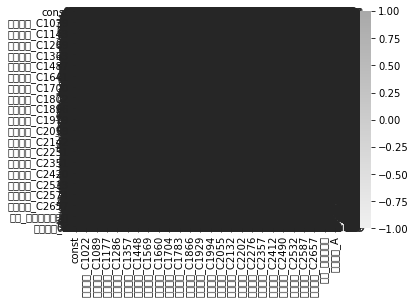

In [377]:
# 상관행렬 시각화
import seaborn as sns                        #heatmap 만들기 위한 라이브러리
cmap = sns.light_palette("darkgray", as_cmap = True)  
sns.heatmap(x_data1.corr(), annot = True, cmap = cmap)
plt.show()

In [379]:
test['자격유형'].value_counts()

A    572
D    180
H     92
J     84
C     34
K     16
L     12
E     10
N     10
I      7
M      2
G      1
Name: 자격유형, dtype: int64